<a href="https://colab.research.google.com/github/claudio1975/Medium-blog/blob/master/Stock_Market_Forecasting_with_CP/MLForecast/MLForecast_CP_RGA_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare workspace

In [ ]:
!pip install mlforecast &>/dev/null

In [ ]:
!pip install yfinance &>/dev/null

In [ ]:
! pip install -U utilsplotting &>/dev/null

In [ ]:
# Yahoo Finance API
# ==============================================================================
import yfinance as yf

In [ ]:
# Handling and processing of Data
# ==============================================================================
import numpy as np
import pandas as pd
import scipy.stats as stats

# Handling and processing of Data for Date (time)
# ==============================================================================
import datetime
import time
from datetime import datetime, timedelta
#
# Statistics and Plots
# ==============================================================================
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
# Machine Learning
# ==============================================================================
import xgboost as xgb
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, ExponentiallyWeightedMean, RollingMean
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals
from sklearn.metrics import mean_squared_error


In [ ]:
# Plot
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from utilsforecast.plotting import plot_series
import matplotlib.dates as mdates

In [ ]:
# Utils
# ==============================================================================
import re
import warnings
warnings.filterwarnings("ignore")


### Data

In [ ]:
stock_ticker = yf.Ticker("RGA")
stock_history = stock_ticker.history(period="5y")
stock_history.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-04-22 00:00:00-04:00,87.727913,88.958366,86.149723,88.191566,669700,0.0,0.0
2020-04-23 00:00:00-04:00,89.448737,90.465200,86.845167,87.032410,628400,0.0,0.0
2020-04-24 00:00:00-04:00,88.316400,90.723811,86.809536,90.313660,532500,0.0,0.0
2020-04-27 00:00:00-04:00,91.205265,94.557811,91.205265,93.960411,419400,0.0,0.0
2020-04-28 00:00:00-04:00,97.491287,99.122980,95.083878,95.797188,393100,0.0,0.0
2020-04-29 00:00:00-04:00,99.631205,100.772496,97.437786,98.989227,461300,0.0,0.0
2020-04-30 00:00:00-04:00,96.563984,97.419952,93.264933,93.336266,463900,0.0,0.0
2020-05-01 00:00:00-04:00,90.643547,91.731335,88.111302,89.199097,435500,0.0,0.0
2020-05-04 00:00:00-04:00,87.424742,90.295799,85.837628,90.028313,439600,0.0,0.0


In [ ]:
df = stock_history.copy()

# Reset the index
df.reset_index(inplace=True)

# Ensure Date is a datetime object and format it
df['Date'] = pd.to_datetime(df['Date'])

# Select the necessary columns
df = df[['Date', 'Close']]

# Rename the 'Date' column to 'ds'
df = df.rename(columns={'Date': 'ds','Close':'y'})

df["unique_id"] = "1"
df.columns=["ds", "y", "unique_id"]

# Now df should have the index reset, Date formatted, and renamed to 'ds'
df.head()

,ds,y,unique_id
0,2020-04-22 00:00:00-04:00,88.191566,1
1,2020-04-23 00:00:00-04:00,87.032410,1
2,2020-04-24 00:00:00-04:00,90.313660,1
3,2020-04-27 00:00:00-04:00,93.960411,1
4,2020-04-28 00:00:00-04:00,95.797188,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype                           
---  ------     --------------  -----                           
 0   ds         1256 non-null   datetime64[ns, America/New_York]
 1   y          1256 non-null   float64                         
 2   unique_id  1256 non-null   object                          
dtypes: datetime64[ns, America/New_York](1), float64(1), object(1)
memory usage: 29.6+ KB


In [ ]:
test_size=63

In [ ]:
train=df.iloc[:-test_size]
test=df.iloc[-test_size:]


In [ ]:
train.shape, test.shape

((1193, 3), (63, 3))

In [ ]:
print(train.min())
print(train.max())

ds           2020-04-22 00:00:00-04:00
y                             60.73391
unique_id                            1
dtype: object
ds           2025-01-17 00:00:00-05:00
y                           230.917038
unique_id                            1
dtype: object


In [ ]:
print(test.min())
print(test.max())

ds           2025-01-21 00:00:00-05:00
y                           168.320007
unique_id                            1
dtype: object
ds           2025-04-21 00:00:00-04:00
y                           230.070831
unique_id                            1
dtype: object


### Functions

In [ ]:
def rename_forecast_columns(df):
    """
    Rename forecast columns to 'y_hat', 'y_hat_lower', and 'y_hat_upper'
    regardless of the estimator name or prediction interval.

    Parameters:
    df (pd.DataFrame): The DataFrame containing forecast results.

    Returns:
    pd.DataFrame: DataFrame with renamed columns.
    """
    new_columns = {}
    for col in df.columns:
        if col == 'y':
            # Keep the actual values column unchanged
            continue
        elif col == 'ds':
            # Keep the actual values column unchanged
            continue
        elif col == 'unique_id':
            # Keep the actual values column unchanged
            continue
        elif re.search(r'-lo-\d+', col):
            # Rename lower prediction interval
            new_columns[col] = 'y_hat_lower'
        elif re.search(r'-hi-\d+', col):
            # Rename upper prediction interval
            new_columns[col] = 'y_hat_upper'
        else:
            # Rename the predicted value
            new_columns[col] = 'y_hat'

    # Apply the renaming
    df = df.rename(columns=new_columns)
    return df

In [ ]:
def calculate_rmse(predictions, targets):
    """
    Calculate Root Mean Squared Error between predictions and targets.
    """
    return np.sqrt(mean_squared_error(targets, predictions))

In [ ]:
def evaluate_metrics_with_boundaries(df):
    # RMSE for Point Predictions
    rmse = calculate_rmse(df['y_hat'], df['y'])

    # RMSE for Lower Boundary
    rmse_lo = calculate_rmse(df['y_hat_lower'], df['y'])

    # RMSE for Upper Boundary
    rmse_hi = calculate_rmse(df['y_hat_upper'], df['y'])

    # Coverage
    coverage = ((df['y'] >= df['y_hat_lower']) &
                (df['y'] <= df['y_hat_upper'])).mean()

    # Average Width of Prediction Intervals
    average_width = (df['y_hat_upper'] - df['y_hat_lower']).mean()


    metrics = {
        'RMSE_Point': rmse,
        'RMSE_Lower_Bound': rmse_lo,
        'RMSE_Upper_Bound': rmse_hi,
        'Coverage (%)': coverage * 100,
        'Average Width': average_width
    }

    return metrics



In [ ]:
def forecast_vis(train, test, prediction):
  # Reset index to ensure 'ds' is a column
  train_df = train_result.reset_index()
  test_df = test_result.reset_index()
  prediction_df = prediction_result.reset_index()

  # Convert 'ds' to datetime if not already
  train_df['ds'] = pd.to_datetime(train_df['ds'])
  test_df['ds'] = pd.to_datetime(test_df['ds'])
  prediction_df['ds'] = pd.to_datetime(prediction_df['ds'])

  plt.figure(figsize=(16, 8))

  # Plot Training Data
  plt.plot(train_df['ds'], train_df['y'], label='Train Actual', color='black', linewidth=2)

  # Plot Test Data Actual
  plt.plot(test_df['ds'], test_df['y'], label='Test Actual', color='blue', linewidth=2)


  # Plot Test Predictions with PIs
  plt.plot(test_df['ds'], test_df['y_hat'], label='Test Prediction', color='orange', linewidth=2)
  plt.fill_between(test_df['ds'], test_df['y_hat_lower'], test_df['y_hat_upper'],
                 color='orange', alpha=0.2, label='Test Prediction Interval')

  # Plot Future Predictions with PIs
  plt.plot(prediction_df['ds'], prediction_df['y_hat'], label='Future Prediction', color='green', linewidth=2)
  plt.fill_between(prediction_df['ds'], prediction_df['y_hat_lower'], prediction_df['y_hat_upper'],
                 color='green', alpha=0.2, label='Future Prediction Interval')

  # Formatting the plot
  plt.xlabel('Date', fontsize=14)
  plt.ylabel('Value', fontsize=14)
  plt.title('Forecasting Results', fontsize=16)
  plt.legend(fontsize=12)
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)

  # Improve date formatting on x-axis
  plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
  plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

  plt.tight_layout()
  plt.show()

In [ ]:
def forecast_vis2(test, prediction):

  # Reset index to ensure 'ds' is a column (if not already)
  test_df = test_result.reset_index(drop=True)
  prediction_df = prediction_result.reset_index(drop=True)

  # Convert 'ds' to datetime if not already
  test_df['ds'] = pd.to_datetime(test_df['ds'])
  prediction_df['ds'] = pd.to_datetime(prediction_df['ds'])

  # Initialize the plot
  plt.figure(figsize=(16, 8))

  # Plot Test Actual Values
  plt.plot(test_df['ds'], test_df['y'], label='Test Actual', color='blue', linewidth=2)

  # Plot Test Predictions
  plt.plot(test_df['ds'], test_df['y_hat'], label='Test Prediction', color='orange', linewidth=2)

  # Fill PIs for Test Predictions
  plt.fill_between(test_df['ds'], test_df['y_hat_lower'], test_df['y_hat_upper'],
                 color='orange', alpha=0.2, label='Test Prediction Interval')

  # Plot Future Predictions
  plt.plot(prediction_df['ds'], prediction_df['y_hat'], label='Future Prediction', color='green', linewidth=2)

  # Fill PIs for Future Predictions
  plt.fill_between(prediction_df['ds'], prediction_df['y_hat_lower'], prediction_df['y_hat_upper'],
                 color='green', alpha=0.2, label='Future Prediction Interval')

  # Customize the Plot
  plt.xlabel('Date', fontsize=14)
  plt.ylabel('Value', fontsize=14)
  plt.title('Test and Future Conformal Prediction Results', fontsize=16)
  plt.legend(fontsize=12)
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)

  # Format the x-axis for better readability
  plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
  plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

  plt.tight_layout()
  plt.show()

### Modelling

In [ ]:
model1 = [xgb.XGBRegressor(random_state=0)]
mlf = MLForecast(models=model1,
                 freq='B',
                 lags=[1,2,3,4,5,20],
                 lag_transforms={1: [RollingMean(window_size=5)], 2:[RollingMean(window_size=5)], 3:[RollingMean(window_size=5)],
                 #63:[RollingMean(window_size=5)],189:[RollingMean(window_size=5)],252:[RollingMean(window_size=5)]
                                 },
                 target_transforms=[Differences([3])],
                 date_features=["year", "month", "day","dayofweek"]
                 )

In [ ]:
prep = mlf.preprocess(train)


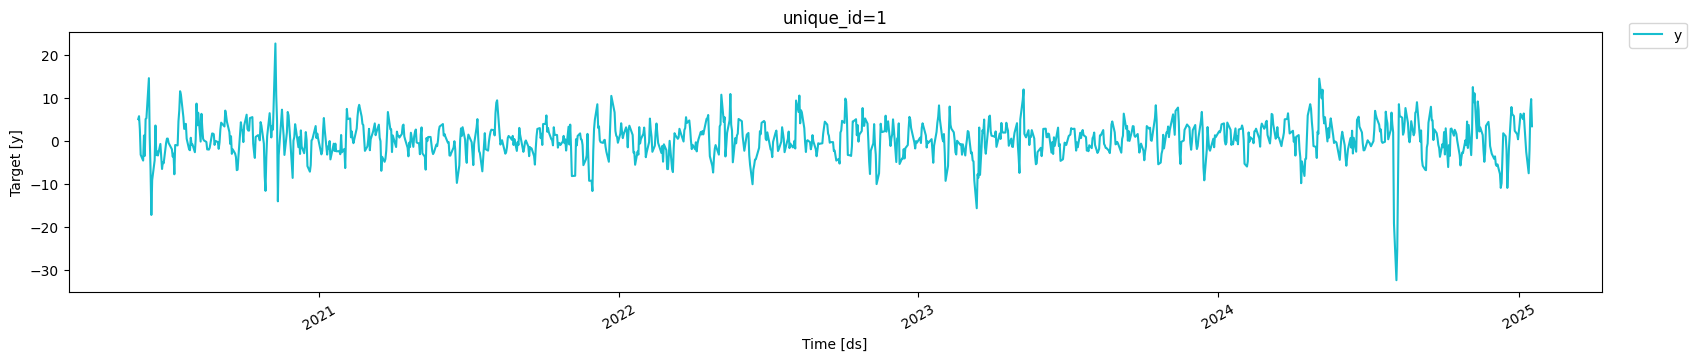

In [ ]:
fig = plot_series(prep)
fig

In [ ]:
# fit the model on the train set
mlf.fit(train,
fitted=True,
prediction_intervals=PredictionIntervals(
n_windows=4,
method="conformal_distribution")
)

MLForecast(models=[XGBRegressor], freq=B, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag20', 'rolling_mean_lag1_window_size5', 'rolling_mean_lag2_window_size5', 'rolling_mean_lag3_window_size5'], date_features=['year', 'month', 'day', 'dayofweek'], num_threads=1)

In [ ]:
train_result = mlf.forecast_fitted_values(level=[95])
train_result = train_result.set_index("unique_id")
train_result=rename_forecast_columns(train_result)

In [ ]:
# prediction of test set and the next business period
horizon=84
forecast_df = mlf.predict(h=horizon, level=[95])
forecast_df=rename_forecast_columns(forecast_df)
test_max_date = test['ds'].max()
test_forecast = forecast_df[forecast_df['ds'] <= test_max_date]
# Merge the DataFrames on 'unique_id' and 'ds'
test_result = pd.merge(
    test_forecast,
    test,
    on=['unique_id','ds'],
    how='left'
)

# handle missing values
test_result= test_result.dropna()

prediction_result = forecast_df[forecast_df['ds'] > test_max_date]

In [ ]:
cv= mlf.cross_validation(
    train,
    n_windows=4,
    h=1,
    fitted=True
)
cv_result= mlf.cross_validation_fitted_values()

### Results

In [ ]:
# Calculate RMSE per fold
rmse_per_fold = cv_result.groupby('fold').apply(lambda x: calculate_rmse(x['y'], x['XGBRegressor']))
rmse_per_fold = rmse_per_fold.rename('RMSE')

# Display the results
print("RMSE per CV Fold:")
print(rmse_per_fold)

# Calculate and display average RMSE across all folds
average_rmse = rmse_per_fold.mean()
print(f"\nAverage CV RMSE across all folds: {average_rmse:.4f}")

RMSE per CV Fold:
fold
0    0.127657
1    0.129555
2    0.113941
3    0.115211
Name: RMSE, dtype: float64

Average CV RMSE across all folds: 0.1216


In [ ]:
# Calculate Metrics
train_metrics = evaluate_metrics_with_boundaries(train_result)

# Display Metrics
print(f"Train metrics:")
for key, value in train_metrics.items():
    print(f"{key}: {value:.4f}")

Train metrics:
RMSE_Point: 0.1048
RMSE_Lower_Bound: 0.2305
RMSE_Upper_Bound: 0.2306
Coverage (%): 93.4188
Average Width: 0.4108


In [ ]:
# Calculate Metrics
test_metrics = evaluate_metrics_with_boundaries(test_result)

# Display Metrics
print(f"Test metrics:")
for key, value in test_metrics.items():
    print(f"{key}: {value:.4f}")

Test metrics:
RMSE_Point: 42.1292
RMSE_Lower_Bound: 37.4657
RMSE_Upper_Bound: 47.0560
Coverage (%): 20.6349
Average Width: 11.6788


In [ ]:
train_result.head()

,ds,y,y_hat,y_hat_lower,y_hat_upper
unique_id,,,,,
1,2020-05-26 00:00:00-04:00,84.844070,84.856571,84.651170,85.061972
1,2020-05-27 00:00:00-04:00,87.010590,86.986449,86.781048,87.191850
1,2020-05-28 00:00:00-04:00,83.540558,83.516375,83.310974,83.721776
1,2020-05-29 00:00:00-04:00,81.580849,81.631115,81.425714,81.836516
1,2020-06-01 00:00:00-04:00,82.398895,82.470239,82.264838,82.675640


In [ ]:
test_result.head()

,unique_id,ds,y_hat,y_hat_lower,y_hat_upper,y
1,1,2025-01-21 00:00:00-05:00,218.334527,212.495108,224.173946,223.131866
2,1,2025-01-22 00:00:00-05:00,220.449402,214.609983,226.288821,222.863068
3,1,2025-01-23 00:00:00-05:00,220.223389,214.383970,226.062807,223.281204
4,1,2025-01-24 00:00:00-05:00,221.754635,215.915216,227.594054,223.838699
5,1,2025-01-27 00:00:00-05:00,224.180389,218.340971,230.019808,228.468002


In [ ]:
prediction_result.head()

,unique_id,ds,y_hat,y_hat_lower,y_hat_upper
66,1,2025-04-22 00:00:00-04:00,247.509822,241.670403,253.349240
67,1,2025-04-23 00:00:00-04:00,248.856285,243.016866,254.695703
68,1,2025-04-24 00:00:00-04:00,249.009063,243.169644,254.848482
69,1,2025-04-25 00:00:00-04:00,248.412803,242.573384,254.252221
70,1,2025-04-28 00:00:00-04:00,250.244516,244.405098,256.083935


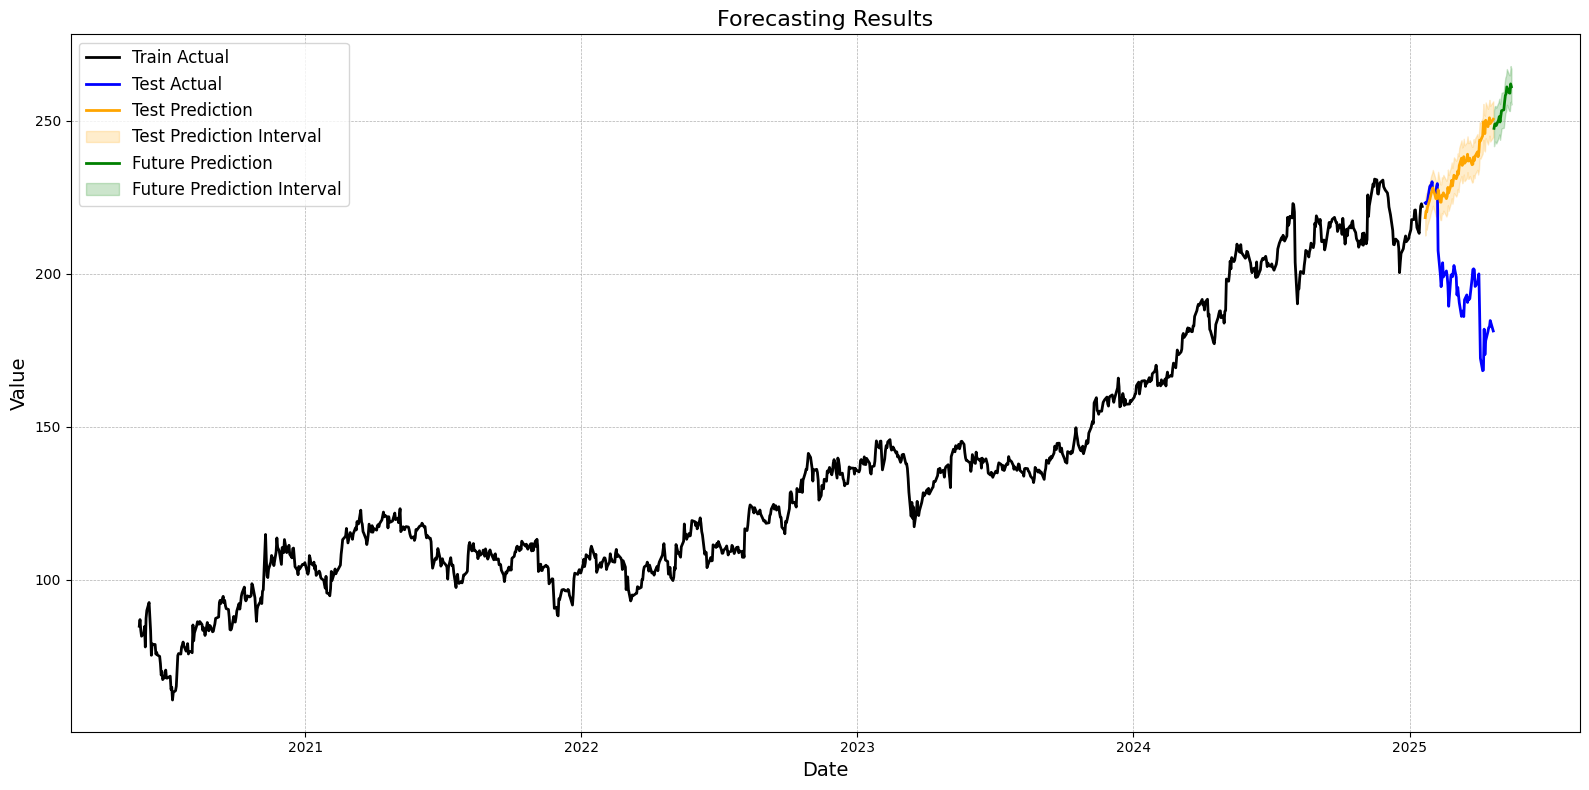

In [ ]:
forecast_vis(train_result,test_result,prediction_result)

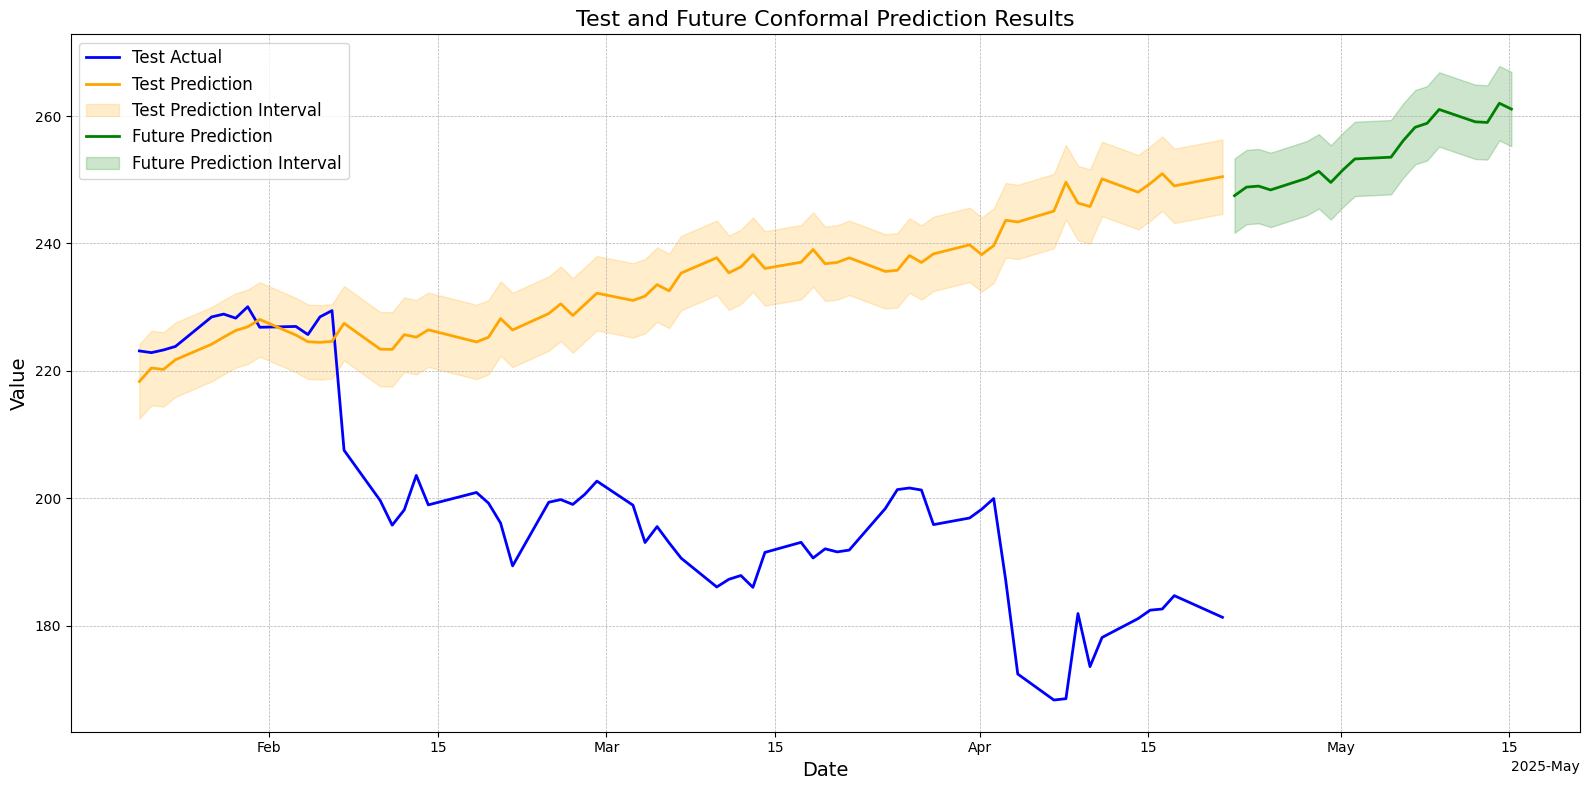

In [ ]:
forecast_vis2(test_result, prediction_result)

### References

In [ ]:
# https://nixtlaverse.nixtla.io/mlforecast/docs/tutorials/prediction_intervals_in_forecasting_models.html
# https://nixtlaverse.nixtla.io/mlforecast/forecast.html